# Fruit Detection

Für den ersten Versuch eines neuronalen Netzes zur Klassifizierung der Bilder soll ein Multi Layer Perceptron Netz in Keras implementiert und evaluiert werden. Aufgrund seiner geringen Komplexität im Vergleich zu anderen Ansätzen bietet dies einen vergleichsweise einfachen Einstieg in die Bildklassifizierung. Außerdem können hierbei die in der Vorlesung behandelten Konzepte angewandt werden.

## Bibliotheken

Wir verwenden die `tf.keras` Library für das neuronale Netz (`model`). Keras bietet eine sehr hohe Abstraktion ("High Level API") auf die Deep Learning Modelle, weshalb es für Einsteiger eine sehr populäre Option darstellt. Des weiteren ermöglicht Keras mit wenig Code ein Modell auszuprobieren und somit schnell einen Ansatz zu evaluieren oder einen Prototypen zu erstellen.
`tf.keras` ist die in Tensorflow integrierte Version von Keras und setzt somit auf der Core API von Tensorflow auf. 

In unserem Prototyp trainieren und evaulieren wir ein `Sequential` Modell, also einen linearen Stack aus Layern.

Als Datenstruktur für die Bilder und später die Tensoren verwenden wir die n-dimensionalen `numpy`-Arrays, da diese mit Fancy-Indexing, der `.shape` Property und den komponentenweise Operationen eine intuitive Arbeitsweise mit Matrizen ermöglicht.

Für die Visualisierung der Ergebnisse setzen wir auf eine Kombination aus `matplotlib` und `Tensorboard`, wobei matplotlib für die Visualisierung der gelabelten Eingabe-Daten und für eine statische Visualisierung der Ergebnisse benutzt wird und Tensorboard dynamische, interaktive Visualisierungen auch über mehrere Ausführungen hinweg generiert. Tensorboard dient entsprechend nicht nur der Dokumentation, sondern auch in hohem Maße der Optimierung des Modells.


In [1]:
import numpy as np
import tensorflow as tf
from time import time

from keras.datasets import cifar100
from keras.callbacks import TensorBoard
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.image import rgb_to_grayscale

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Vorverarbeitung der Daten

### Herunterladen und Split in Trainings- und Testdatensatz

Der cifar100-Datensatz wird mit der `load_data()`-Methode aus dem Archiv des Canadian Institute For Advanced Research heruntergeladen, entpackt und in der Form von 2 Tupeln für die gelablten Trainings- und Testdaten zurückgegeben. Der Datensatz setzt sich aus Kategorien samt Subkategorien zusammen. Über das Argument label_mode fordern wir alle Subkategorien an. 
Diese Trainings- bzw- Test-Tupel bestehen wiederum selbst aus 2 uint8-Numpy-Arrays der shape (50000, 32, 32, 3). Die Bilder sind also 32x32 Pixel groß und haben 3 Farbkanäle (R,G,B). 

Die Labels sind ebenfalls uint8-Numpy-Arrays, allerdings nur 2-dimensional (50000 Labels mit je einem Index, der zu einer bestimmten Bildklasse gehört).

Mit Hilfe der Unpacking Syntax lassen sich die Rückgabe-Tupel in ihre Numpy-Array Bestandteile destrukturieren und diese direkt einer Variablen zuweisen. Es werden also 4 separate Variablen mit nur einer Codezeile definiert und initialisiert.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
print("Image Data Shape:", x_train.shape)
print("Data Type of Images:", type(x_train))
print("Labels Shape:", y_train.shape)

Image Data Shape: (50000, 32, 32, 3)
Data Type of Images: <class 'numpy.ndarray'>
Labels Shape: (50000, 1)


### Filtern der relevanten Klassen

Da wir mit unserem Modell nur **Früchte** klassizieren möchten, reduzieren wir unsere Daten auf die Kategorien: **Apple**, **Orange**, **Pear**. Diese Klassen entsprechen den Labels mit folgenden Indices: Apple = 0, Orange = 53, Pear = 57.

In [3]:
# Wir filtern die Numpy Arrays mittels Numpy Fancy Indexing nach Indices 
# der Werte 0, 53 oder 57
indices_train = np.argwhere((y_train == 0) | (y_train == 53) | (y_train == 57))[:,0]
indices_test = np.argwhere((y_test == 0) | (y_test == 53) | (y_test == 57))[:,0]
# Wir reduzieren unsere Trainings- und Test-Labels auf die Einträge mit Früchten
y_train = np.array(y_train[indices_train])
y_test = np.array(y_test[indices_test])
# Selbiges tun wir für die Trainings- und Testdaten.
x_train = x_train[np.ravel(indices_train)]
x_test = x_test[np.ravel(indices_test)]

# Nun müssen wir nur noch die Werte auf 0, 1 und 2 mappen, dann entsprechen
# die Werte den Indize einer Liste der Länge 3

def mapLabels(y):
  if y == 53: return [1]
  elif y == 57: return [2]
  else: return [0]
  
y_train = np.array(list(map(mapLabels, y_train[:,0].tolist())))
y_test = np.array(list(map(mapLabels, y_test[:,0].tolist())))

# Die Liste beinhaltet die "menschlich lesbaren Kategorien", das Netz arbeitet
# ausschließlich mit den Indices.

class_names = ["Apfel", "Orange", "Birne"]

In [4]:
'''
x_train = tf.Session().run(rgb_to_grayscale(
    x_train,
    name=None
))
x_test = tf.Session().run(rgb_to_grayscale(
    x_test,
    name=None
))

# Drop last dimension
x_train = x_train[:,:,:,0]
x_test = x_test[:,:,:,0]

print(x_train[0].shape)
'''

'\nx_train = tf.Session().run(rgb_to_grayscale(\n    x_train,\n    name=None\n))\nx_test = tf.Session().run(rgb_to_grayscale(\n    x_test,\n    name=None\n))\n\n# Drop last dimension\nx_train = x_train[:,:,:,0]\nx_test = x_test[:,:,:,0]\n\nprint(x_train[0].shape)\n'

In [5]:
# TIM BITTE NOCH CODE BESCHREIBEN
x_train = x_train / 255.0

x_test = x_test / 255.0

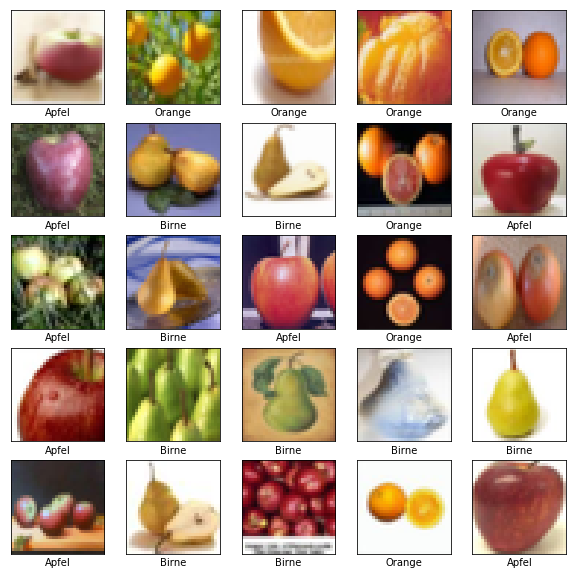

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.asscalar(y_train[i])])

In [7]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
# Initialisierung des ersten hidden Dense-Layers mit Anzahl
# der Pixel als Neuronen.
model.add(Dense(1024, activation="relu"))
# Initialisierung des Output-Layers mit der Anzahl der Klassen.
model.add(Dense(3, activation="softmax"))

In [8]:
model.compile(optimizer="Adam", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [9]:
tensorboardCb = TensorBoard(log_dir="logs/{}".format(time()))

In [22]:
# Splitten Trainingsdatensatz in Training und Validierung
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20)

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid))

Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2658 - acc: 0.9021 - val_loss: 0.2783 - val_acc: 0.8833
Epoch 2/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2570 - acc: 0.9073 - val_loss: 0.1945 - val_acc: 0.9500
Epoch 3/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2038 - acc: 0.9281 - val_loss: 0.2982 - val_acc: 0.8917
Epoch 4/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2043 - acc: 0.9312 - val_loss: 0.1824 - val_acc: 0.9417
Epoch 5/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2488 - acc: 0.9031 - val_loss: 0.2990 - val_acc: 0.8667
Epoch 6/50
960/960 [==============================] - 1s 1ms/step - loss: 0.2283 - acc: 0.9167 - val_loss: 0.4008 - val_acc: 0.8833
Epoch 7/50
960/960 [==============================] - 1s 1ms/step - loss: 0.1901 - acc: 0.9375 - val_loss: 0.2245 - val_acc: 0.9125
Epoch 8/50
960/960 [==========

In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

300/300 [==============================] - 0s 259us/step
Test accuracy: 0.7599999992052714


In [32]:
predictions = model.predict(x_test)

# Vorhersagen der Testdaten-Labels.
y_pred = model.predict_classes(x_test, verbose=0)

# Berechnen der Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[78  9 13]
 [ 8 71 21]
 [16  5 79]]


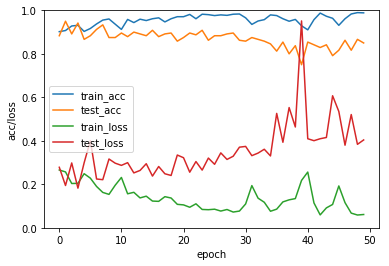

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('acc/loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='best')
plt.show()

In [34]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[np.asscalar(predicted_label)],
                                100*np.max(predictions_array),
                                class_names[np.asscalar(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i].tolist(), true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[np.asscalar(predicted_label)].set_color('red')
  thisplot[np.asscalar(true_label)].set_color('blue')

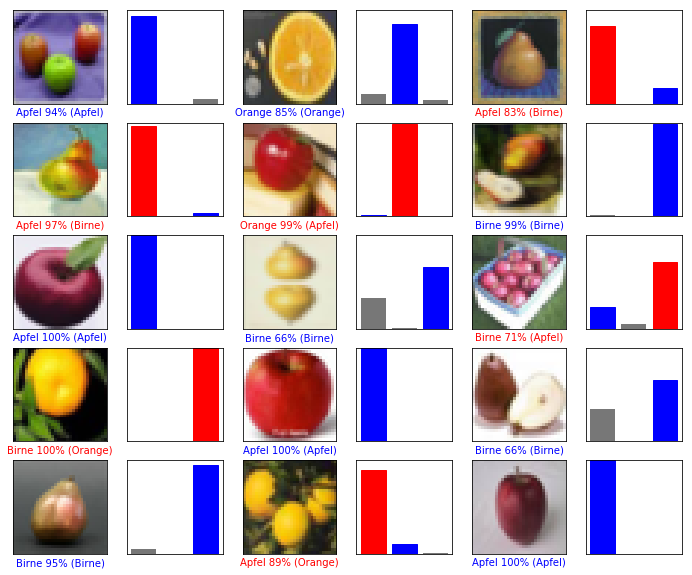

In [35]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test)